In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from livelossplot import PlotLosses
import torch
# %pylab inline

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from torchvision import transforms



import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
# from torchsummary import summary

In [2]:
# # # standardise data

def apply_standardization(X): # define an standardisation function
#     X = X.astype(float)
    X /= 255.
    X -= 0.1307
    X /= 0.3081
    return X


In [3]:
import torch

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")
    device = 'cpu'

No GPU available!


In [4]:
from torch.utils.data import DataLoader, Subset, random_split
# set up transforms for data
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts a PIL Image or numpy.ndarray to a tensor.
    
    # Add any other transforms you might need, such as normalization.
])

# get (transformed) data
from torchvision.datasets import MNIST
mnist_train_val = MNIST("./", download=True, train=True, transform=transform)

mnist_test = MNIST("./", download=True, train=False, transform=transform)
mnist_train, mnist_val = random_split(mnist_train_val, [50_000, 10_000])


In [5]:
# fit into dataloader objects
batch_size = 1
train_loader = data.DataLoader(
    mnist_train, 
    batch_size=batch_size, 
    shuffle=True, 
    pin_memory=True)

val_loader = data.DataLoader(
    mnist_val, 
    batch_size=batch_size, 
    shuffle=True, 
    pin_memory=True)

test_loader = data.DataLoader(
    mnist_test, 
    batch_size=batch_size, 
    shuffle=True, 
    pin_memory=True)

In [6]:
batch_size = 16
dimensions = [784, 200, 50, 10]
lr = 1e-4
momentum = 1e-4

In [7]:
# todo: vectorize
for loader in [train_loader, val_loader, test_loader]:
    for image, label in loader:
        image = apply_standardization(image)

In [8]:
# split x/y
# # # X_train = []
# # # y_train = []
# # # X_val = []
# # # y_val = []
# # # X_test = []
# # # y_test = []
    

In [9]:
train_loader = data.DataLoader(
    mnist_train, 
    batch_size=batch_size, 
    shuffle=True, 
    pin_memory=True,)

val_loader = data.DataLoader(
    mnist_val, 
    batch_size=batch_size, 
    shuffle=True, 
    pin_memory=True)

test_loader = data.DataLoader(
    mnist_test, 
    batch_size=batch_size, 
    shuffle=True, 
    pin_memory=True)

In [10]:
# fit into dataloader objects
train_loader = data.DataLoader(
    mnist_train, 
    batch_size=batch_size, 
    shuffle=True, 
    pin_memory=True)

val_loader = data.DataLoader(
    mnist_val, 
    batch_size=batch_size, 
    shuffle=True, 
    pin_memory=True)

test_loader = data.DataLoader(
    mnist_test, 
    batch_size=batch_size, 
    shuffle=True, 
    pin_memory=True)

In [11]:
class simpleFFN(nn.Module):
    def __init__(self, dimensions):
        super(simpleFFN, self).__init__()
        # fully connected
        self.fc1 = nn.Linear(dimensions[0], dimensions[1], bias=False)
        self.fc2 = nn.Linear(dimensions[1], dimensions[2], bias=False)
        self.fc3 = nn.Linear(dimensions[2], dimensions[-1], bias=False)
        # activation functions/special
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()
        self.dropout = nn.Dropout(0.5)

    def forward(self, X):
        out = self.fc1(X)
        out = self.tanh(out)
        out = self.fc2(out)
        out = self.tanh(out)
        out = self.fc3(out)
        return out
    
def train(model, optimizer, criterion, data_loader):
    model.train()                         # the model is in the training mode so the parameters(weights)to be optimised will be updated
    train_loss, train_accuracy = 0, 0     # initialise loss and accuracy to 0 for training
    for i, (X, y) in enumerate(data_loader):#np.array(data_loader):              # iterate over the mini-batches defined in the data loader
        #
#         X = np.array(X)
#         y = np.array(y)
        #
        
        X, y = X.to(device), y.to(device) # send data to the device (GPU in our case)
        optimizer.zero_grad()             # resetting optimiser info
        outputs = model(X.view(-1, 28*28))     # forward pass
        loss = criterion(outputs, y)           # compute loss
        loss.backward()                   # backpropagation to calculate the gradients
        train_loss += loss*X.size(0)      # # add it up for different mini-batches and undo loss normalisation
        # non functional
        y_pred = F.log_softmax(outputs, dim=1).max(1)[1]  # get predictions
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0) # compute accuracy
        # non functional
        optimizer.step()                  # perform a step of gradient descent
        if i % 1000 == 0:
            print(i)
            
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)  # here we can average over the whole dataset


def validate(model, criterion, data_loader):      # does not need optimiser
    model.eval()                                  # model is set to evaluation mode so no dropout or any other funny stuff here
    validation_loss, validation_accuracy = 0., 0. # initialise loss and accuracy to 0 for training
    for X, y in data_loader:                      # iterate over the mini-batches defined in the data loader
        with torch.no_grad():                     # deactivates autograd engine
            X, y = X.to(device), y.to(device)     # send data to the device (GPU in our case)
            outputs = model(X.view(-1, 28*28))         # forward pass
            loss = criterion(outputs, y)               # evaluate loss
            validation_loss += loss*X.size(0)     # add it up for different mini-batches and undo loss normalisation
            y_pred = F.log_softmax(outputs, dim=1).max(1)[1]  # get predictions
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0) # compute accuracy

    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)  # here we can average over the whole dataset


In [12]:
model = simpleFFN(dimensions).to(device)                                              # instantiate model and send it to the GPU
# optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)   # instantiate the optimizer
optimizer = torch.optim.Adam(model.parameters())   # instantiate the optimizer
loss_func = nn.CrossEntropyLoss()

In [13]:
# single epoch
# train(model=model, 
#       optimizer=optimizer, 
#       criterion=loss_func, 
#       data_loader=train_loader)

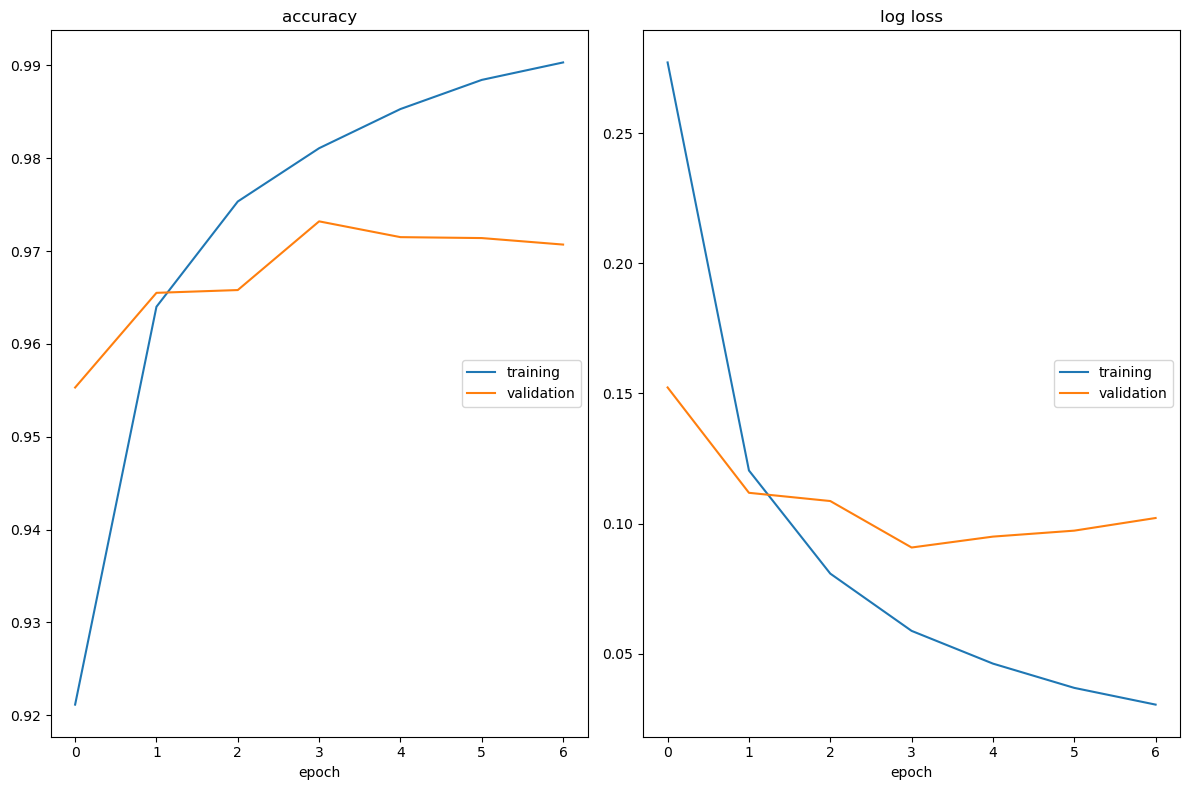

accuracy
	training         	 (min:    0.921, max:    0.990, cur:    0.990)
	validation       	 (min:    0.955, max:    0.973, cur:    0.971)
log loss
	training         	 (min:    0.031, max:    0.277, cur:    0.031)
	validation       	 (min:    0.091, max:    0.152, cur:    0.102)
0.10218186676502228


In [14]:
liveloss = PlotLosses()
for epoch in range(1, 8):
    
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, loss_func, train_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()

    validation_loss, validation_accuracy = validate(model, loss_func, val_loader)
    logs['val_' + 'log loss'] = validation_loss.item()
    logs['val_' + 'accuracy'] = validation_accuracy.item()

    liveloss.update(logs)
    liveloss.draw()
    print(validation_loss.item())

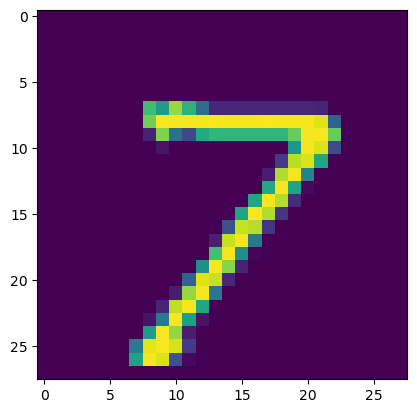

In [15]:
# testing model

# # making an iterator
train_loader_iter = iter(train_loader)
# # plotting the first iter
plt.imshow(next(train_loader_iter)[0][0].view(28,28))
# # predicting a batch
# model(next(train_loader_iter)[0].reshape(-1, 28*28,))

In [16]:
:

SyntaxError: invalid syntax (1305497275.py, line 1)

In [ ]:
validate(model, loss_func, test_loader)

In [ ]:
def get_all_preds(model, criterion, data_loader):
    
    predictions = []
    labels = []
    
    model.eval()                                  # model is set to evaluation mode so no dropout or any other funny stuff here
    validation_loss, validation_accuracy = 0., 0. # initialise loss and accuracy to 0 for training
    for X, y in data_loader:                      # iterate over the mini-batches defined in the data loader
        with torch.no_grad():                     # deactivates autograd engine
            X, y = X.to(device), y.to(device)     # send data to the device (GPU in our case)
            outputs = model(X.view(-1, 28*28))         # forward pass
            loss = criterion(outputs, y)               # evaluate loss
            y_pred = F.log_softmax(outputs, dim=1).max(1)[1]  # get predictions
            labels.append(y.cpu().numpy())
            predictions.append(y_pred.cpu().numpy())
    return list(np.array([list(i) for i in labels]).reshape(-1)), list(np.array([list(i) for i in predictions]).reshape(-1))

In [ ]:
acc, pred = get_all_preds(model, loss_func, test_loader)

In [ ]:
accuracy_score(acc, pred)

In [ ]:
# [item for sublist in pred for item in sublist]